In [1]:
import pandas as pd
from tqdm import tqdm
# from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_score,adjusted_mutual_info_score,completeness_score, homogeneity_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans,DBSCAN, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import TSNE
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.text import TSNEVisualizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer
from collections import Counter
import random
from coclust.evaluation.external import accuracy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# from sklearn.utils.linear_assignment_ import linear_assignment
rs = 42 # random state
np.random.seed(rs)

/home/tudor/.miniconda3/envs/pml/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [2]:
def random_prediction(X, y):
    labels = list(set(y))
    predictions = [np.random.choice(labels) for _ in X]
    return accuracy_score(y, predictions)

def get_random_prediction(X_test, y_test, trials=1000):
    np.random.seed()
    sum = 0
    trials
    for i in tqdm(range(trials)):
        sum += random_prediction(X_test, y_test)
    np.random.seed(rs)
    return sum/trials

colors = ['blue', 'green', 'chocolate', 'gold', 'yellow', 'lime' , 'pink', 'fuchsia']
centroid_color = ['red']

def plot_clusters(X, y_true, y_pred , mode=None, centroids=None):
    # this was inspired from the plot2d from the lab exercises
    transformer = None
    X_rescaled = X
    
    if mode is not None:
        transformer = mode(n_components=2, random_state=42)
        if mode == TSNE:
            if centroids is not None:
                X_centroids = np.append(X, centroids, axis=0)
                X_centroids = transformer.fit_transform(X_centroids)
                X_rescaled = X_centroids[:X.shape[0]]
 
        X_rescaled = transformer.fit_transform(X)

    for x, yp in zip(X_rescaled, y_pred):
        plt.plot(x[0], x[1], 
                    c=colors[yp], 
                    marker='*',
                    label = str(yp)
                )
        
    if centroids is not None:
        # TNSE does not plot correctly the centroids
        C_rescaled = centroids
        if transformer is not None:
            if mode == TSNE:
                C_rescaled = X_centroids[-1 * centroids.shape[0]:]
            elif mode == PCA:
                C_rescaled = transformer.fit_transform(centroids)
            
        for c in C_rescaled:
            plt.plot(c[0], c[1], 
                        marker='X', 
                        markersize=10,
                        c='red')
#     plt.legend()
    plt.show()
    
def plot_dbscan(model, X, mode=None):
    # this was inspired from the sklearn example of using DBSCAN
    core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
    core_samples_mask[model.core_sample_indices_] = True

    unique_labels = set(model.labels_)
    n_clusters = len(unique_labels) - 1
    colors = plt.cm.get_cmap('rainbow', len(unique_labels))
    
    X_rescaled = X
    if mode is not None:
        transformer = mode(n_components=2, random_state=42)
        X_rescaled = transformer.fit_transform(X)

    
    for index, label  in enumerate(unique_labels):
        if label == -1:
            c = (0, 0, 0, 1)
#             continue
        else:
            c = colors(index)
        class_member_mask = (model.labels_ == label)

        x = X_rescaled[class_member_mask & core_samples_mask]
        plt.plot(x[:, 0], x[:, 1], 'o', color=c, markersize=10)

        x = X_rescaled[class_member_mask & ~core_samples_mask]
        plt.plot(x[:, 0], x[:, 1], '*',color=c, markersize=2)

    plt.title(f'No of clusters: {n_clusters}')
    plt.show()

def score_results(X, true_labels, predicted_labels):
    metrics = {
                'Completeness Score': completeness_score,
                'homogeneity Score': homogeneity_score,
                'Accuracy': accuracy
              } 
    for name, func in metrics.items():
        print(f'{name}:\t {round(func(true_labels, predicted_labels), 5) : >5}')
        
    assert(len(set(predicted_labels)) > 1), f"Not enough no. of labels ( {len(set(predicted_labels))} < 2 ) "
    print(f'Silhouette Score:\t {round(silhouette_score(X, predicted_labels, random_state=rs), 5) : >5}')
    

def plot_distance(distances, min_=None,max_=None):
    
    plt.subplot(1, 2, 1)
    dist = distances[:,1]
    plt.plot(dist)
    
    if max_ and min_ :
        
        max_ = min(max_, len(dist))
        plt.subplot(1, 2, 2)
        zoom_in = distances[min_: max_,1]
        x_axis = np.arange(min_, max_)
        plt.plot(x_axis,zoom_in)
        plt.tight_layout()

    plt.show()

In [3]:
path = r'./data/processed_full.csv'
samples = 1000
data = pd.read_csv(path)
new_data = pd.DataFrame()
cols = ['rock', 'electronic', 'rap', 'pop/r&b', 'folk/country', 'experimental', 'metal', 'jazz']
# cols = ['rock', 'electronic', 'rap', 'pop/r&b']
# cols = ['rock', 'electronic']
for col in cols:
    try:
        aux = data[data['genre'] == col].sample(samples, axis=0, random_state=rs)
    except:
        sub_sample = len(data[data['genre'] == col])
        aux = data[data['genre'] == col].sample(sub_sample, axis=0, random_state=rs)
    new_data =  pd.concat([aux, new_data], ignore_index=True, axis=0)

data = new_data.sample(frac=1).reset_index(drop=True)
X = data.content.apply(lambda x: np.str_(x))
y = data.genre.apply(lambda x: np.str_(x))

In [4]:
colect = Counter(data.genre).most_common(10)
n_clusters = len(colect)
print(f"The number of cluster is {n_clusters} out of {len(data.index)} items:")
for gen, app in colect:
    print(f"{gen} :{app}")

The number of cluster is 8 out of 5834 items:
pop/r&b :1000
rock :1000
electronic :1000
rap :1000
folk/country :574
experimental :562
metal :357
jazz :341


# Transform data TD-IDF/TD-IDF with 2_n_grams/TD-IDF + TSNE

In [5]:
min_apparitions = 10
max_nr_features = 150
max_apparitions = 100
lower_case = True
params_tfidf = {
    'min_df': min_apparitions,
    'max_features': max_nr_features,
    'lowercase': lower_case,
    'max_df': max_apparitions,
    'stop_words': 'english'}
params_dr = {'n_components':2, 'random_state': rs }

In [6]:
tfidf = TfidfVectorizer(**params_tfidf)
tfidf_ngrams = TfidfVectorizer(ngram_range=(2,2), **params_tfidf,analyzer='char_wb')
tfidf_12ngrams = TfidfVectorizer(ngram_range=(1,2), **params_tfidf,analyzer='char_wb')
pca = PCA(**params_dr)
tsne = TSNE(**params_dr)

X_tfidf  = tfidf.fit_transform(X)
# X_tfidf = X_tfidf.todense()
le = LabelEncoder()
y_labels = le.fit_transform(y)

In [7]:
print(X_tfidf.shape)

(5834, 150)


# Baseline prediction

In [45]:
result = float(round(random_prediction(X_tfidf, y_labels), 4)) * 100
print(f"The probability is {result}%")

The probability is 12.43%


# Random Forest

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y_labels, stratify=y, random_state=rs)
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = RandomForestClassifier()
model.fit(X_train, y_train)
result = round(model.score(X_test, y_test), 2) * 100
print(f'Random forest Classification {result}%')

Random forest Classification 57.99999999999999%


# k Means

In [10]:
kmeans = KMeans(n_clusters=n_clusters, random_state=rs)
kmeans.fit(X_tfidf)
score_results(X_tfidf, y_labels, kmeans.labels_)

Completeness Score:	 0.06936
homogeneity Score:	 0.01578
Accuracy:	 0.18615
Silhouette Score:	 0.09465


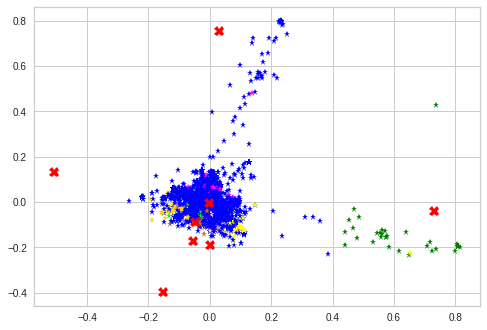

In [11]:
plot_clusters(X_tfidf.todense(), y_labels, kmeans.labels_ , mode=PCA, centroids=kmeans.cluster_centers_)

## TSNE

In [47]:
X_tfidf_tsne = tsne.fit_transform(X_tfidf)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=rs)
kmeans_tsne.fit(X_tfidf_tsne)
score_results(X_tfidf_tsne, y_labels, kmeans_tsne.labels_)

Completeness Score:	 0.04052
homogeneity Score:	 0.04089
Accuracy:	 0.20689
Silhouette Score:	 0.3740699887275696


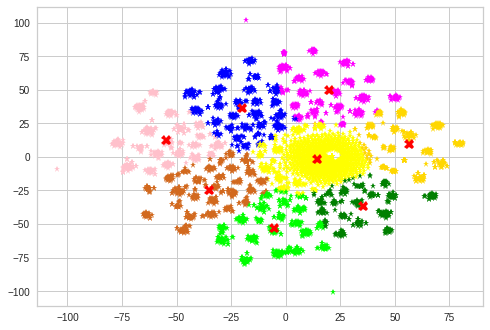

In [48]:
plot_clusters(X_tfidf_tsne, y_labels, kmeans_tsne.labels_, centroids=kmeans_tsne.cluster_centers_)

## PCA

In [49]:
X_tfidf_pca = pca.fit_transform(X_tfidf.todense())
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=rs)
kmeans_pca.fit(X_tfidf_pca)
score_results(X_tfidf_pca, y_labels, kmeans_pca.labels_)

Completeness Score:	 0.08039
homogeneity Score:	 0.06013
Accuracy:	 0.22849
Silhouette Score:	 0.43316


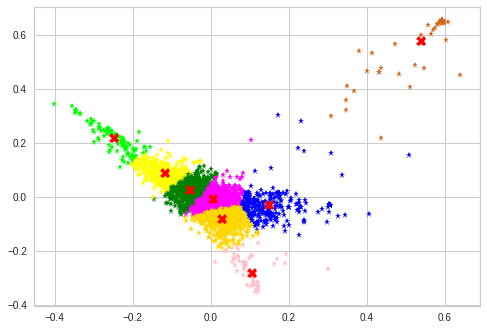

In [50]:
plot_clusters(X_tfidf_pca, y_labels, kmeans_pca.labels_, centroids=kmeans_pca.cluster_centers_)

## DBSCAN

## TSNE

In [13]:
X_tfidf_tsne = tsne.fit_transform(X_tfidf)

In [14]:
nn_tsne = NearestNeighbors(n_jobs=-1).fit(X_tfidf_tsne)
distances, idx = nn_tsne.kneighbors(X_tfidf_tsne)
distances_tsne = np.sort(distances, axis=0)

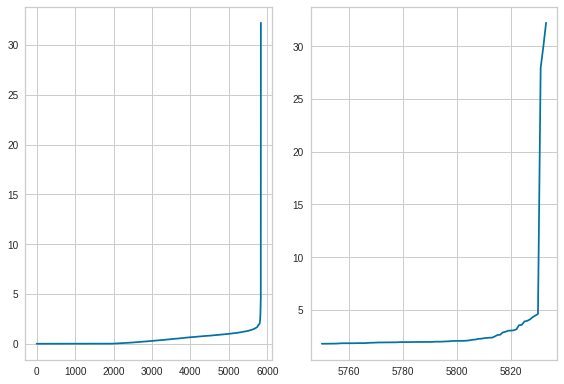

In [15]:
plot_distance(distances_tsne, 5750, 6000)

In [34]:
eps_tsne = 4.8

dbscan_tsne = DBSCAN(eps=eps_tsne,min_samples=50, n_jobs=-1)
dbscan_tsne.fit(X_tfidf_tsne)

DBSCAN(algorithm='auto', eps=4.8, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=50, n_jobs=-1, p=None)

Completeness Score:	 0.05922
homogeneity Score:	 0.02358
Accuracy:	 0.19523
Silhouette Score:	 -0.31248000264167786


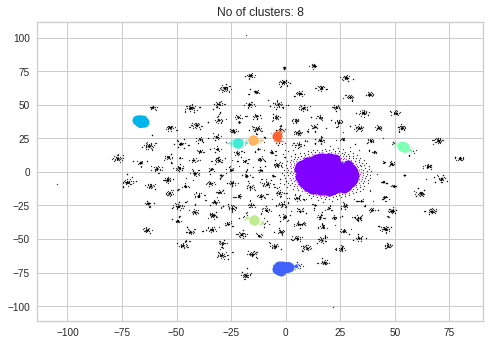

In [35]:
score_results(X_tfidf_tsne,y_labels, dbscan_tsne.labels_)
plot_dbscan(dbscan_tsne, X_tfidf_tsne)

## PCA

In [18]:
X_tfidf_pca = pca.fit_transform(X_tfidf.todense())
X_tfidf_pca_norm = Normalizer().fit_transform(X_tfidf_pca)
nn_pca = NearestNeighbors(n_jobs=-1).fit(X_tfidf_pca_norm)
distances_pca, idx = nn_pca.kneighbors(X_tfidf_pca_norm)
distances_pca = np.sort(distances_pca, axis=0)

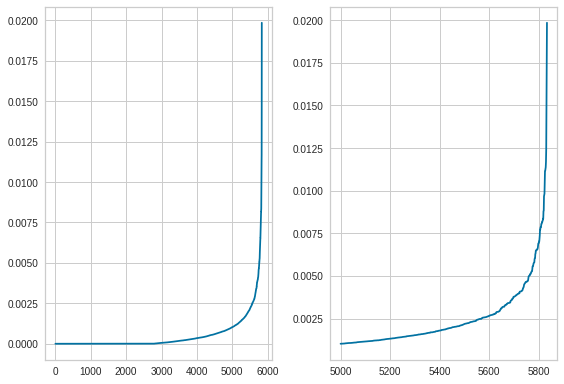

In [19]:
plot_distance(distances_pca, 5000, 6000)

In [43]:
eps_tsne = 0.005
dbscan_pca = DBSCAN(eps=eps_tsne,min_samples=40, n_jobs=-1)
dbscan_pca.fit(X_tfidf_pca)



DBSCAN(algorithm='auto', eps=0.005, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=40, n_jobs=-1, p=None)

Completeness Score:	 0.02429
homogeneity Score:	 0.01169
Accuracy:	 0.211
Silhouette Score:	 -0.24848


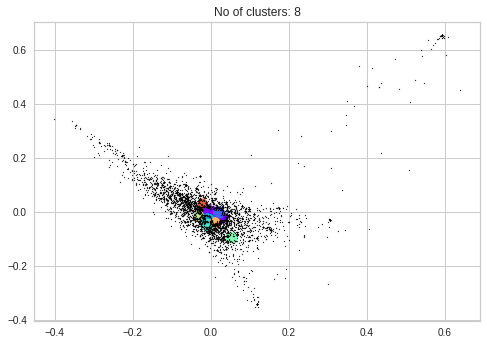

In [44]:
score_results(X_tfidf_pca,y_labels, dbscan_pca.labels_)
plot_dbscan(dbscan_pca, X_tfidf_pca)